In [1]:
from db_connection import create_connection, query_data, query_sql_file, select_table

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Connect to MIMIC-III dataset
con = create_connection()

# Heart Rate in Adult Patients

In [4]:
# query = \
# """
# WITH agetbl AS
# (
#   SELECT ad.subject_id
#   FROM admissions ad
#   INNER JOIN patients p
#   ON ad.subject_id = p.subject_id
#   WHERE
#   -- filter to only adults
#   EXTRACT(YEAR FROM age(ad.admittime, p.dob)) > 15
#   -- group by subject_id to ensure there is only 1 subject_id per row
#   group by ad.subject_id
# )
# , hr as
# (
#   SELECT width_bucket(valuenum, 0, 300, 301) AS bucket
#   FROM chartevents ce
#   INNER JOIN agetbl
#   ON ce.subject_id = agetbl.subject_id
#   WHERE itemid in (211,220045)
# )
# SELECT bucket as heart_rate, count(*)
# FROM hr
# GROUP BY bucket
# ORDER BY bucket;
# """
#
# heart_rates_adults = query_data(query, con)
# print(heart_rates_adults.head())

In [5]:
# plt.bar(heart_rates_adults['heart_rate'], heart_rates_adults['count'])
# plt.title('Histogram of Heart Rates')
# plt.xlabel('Heart Rate Bucket')
# plt.ylabel('Count')
# plt.show()

# Temperature in Adult Patients

In [6]:
# query  = \
# """
# WITH agetbl AS
# (
#   SELECT ad.subject_id, ad.hadm_id
#   FROM admissions ad
#   INNER JOIN patients p
#   ON ad.subject_id = p.subject_id
#   WHERE
#   -- filter to only adults
#   EXTRACT(YEAR FROM age(ad.admittime, p.dob)) > 15
#   -- group by subject_id to ensure there is only 1 subject_id per row
#   group by ad.subject_id, ad.hadm_id
# )
# , temp as
# (
#   SELECT width_bucket(
#       CASE
#         WHEN itemid IN (223762, 676, 677) THEN valuenum -- celsius
#         WHEN itemid IN (223761, 678, 679) THEN (valuenum - 32) * 5 / 9 --fahrenheit
#       END
#     , 30, 45, 160) AS bucket
#   FROM chartevents ce
#   INNER JOIN agetbl
#   ON ce.hadm_id = agetbl.hadm_id
#   WHERE itemid IN
#   (
#       676 -- Temperature C
#     , 677 -- Temperature C (calc)
#     , 678 -- Temperature F
#     , 679 -- Temperature F (calc)
#     , 223761 -- Temperature Fahrenheit
#     , 223762 -- Temperature Celsius
#   )
# )
# SELECT round((cast(bucket as numeric)/10) + 30,2) as temperature, count(*)
# FROM temp
# GROUP BY bucket
# ORDER BY bucket;
# """
# temperature_adults = query_data(query, con)
# plt.bar(temperature_adults['temperature'], temperature_adults['count'])
# plt.title('Histogram of Temperature Measurements in Adult Patients')
# plt.xlabel('Temperature Bucket')
# plt.ylabel('Count')
# plt.show()

# Vital Signs for First Day of Admission

In [7]:
script = query_sql_file('../sql_scripts/vital_signs/vital_signs_first_day.sql', con)
df = query_data(script[0], con)
df.head()

,subject_id,hadm_id,icustay_id,heartrate_min,heartrate_max,heartrate_mean,sysbp_min,sysbp_max,sysbp_mean,diasbp_min,...,spo2_mean,glucose_min,glucose_max,glucose_mean,ph_min,ph_max,ph_mean,weight_min,weight_max,weight_mean
0,2,163353,243653,140.0,140.0,140.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,145834,211552,75.0,168.0,111.785714,64.0,217.0,102.960000,28.0,...,97.870968,136.0,306.0,232.416667,7.26,7.59,7.36,96.800003,96.800003,96.800003
2,4,185777,294638,74.0,111.0,89.217391,97.0,139.0,118.000000,55.0,...,97.500000,153.0,266.0,199.666667,NaN,NaN,NaN,NaN,NaN,NaN
3,6,107064,228232,76.0,100.0,84.160000,127.0,187.0,153.647059,40.0,...,99.200000,102.0,181.0,148.500000,NaN,NaN,NaN,NaN,NaN,NaN
4,7,118037,236754,115.0,121.0,118.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.to_csv('../dataset/firstday_vital_signs.csv')

In [9]:
# Handling Missing Data
vital_signs = [col for col in df.columns if col not in ['subject_id', 'hadm_id', 'icustay_id']]
for vital_sign in vital_signs:
    df[vital_sign].fillna(df[vital_sign].median(), inplace=True)

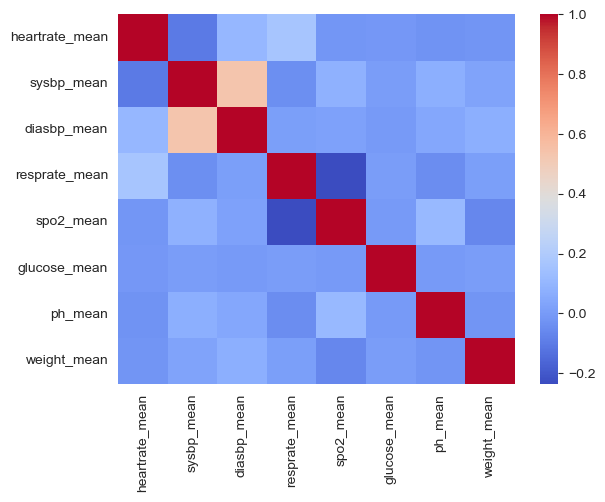

In [10]:
# Correlation Matrix Plot
vital_signs = ['heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'resprate_mean',
               'spo2_mean', 'glucose_mean', 'ph_mean', 'weight_mean']
corr = df[vital_signs].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm')
plt.savefig('../data_viz_img/corr_vital_signs.png')
plt.show()

In [11]:
# Check the features with a correlation coefficient > 0.6
high_corr = {}
for col in corr.columns:
    high_corr[col] = corr.index[corr[col] < -0.1].tolist()

# Remove self-correlation
# for key, values in high_corr.items():
#     values.remove(key)

high_corr

{'heartrate_mean': ['sysbp_mean'],
 'sysbp_mean': ['heartrate_mean'],
 'diasbp_mean': [],
 'resprate_mean': ['spo2_mean'],
 'spo2_mean': ['resprate_mean'],
 'glucose_mean': [],
 'ph_mean': [],
 'weight_mean': []}

In [12]:
admissions = pd.read_csv('../dataset/patient_stay_data.csv')
admissions.head()

,subject_id,hadm_id,admission_type,admission_location,ethnicity,hospital_expire_flag,total_los,gender,expire_flag,age_at_admission,...,Diseases Of The Genitourinary System,Complications Of Pregnancy Childbirth And The Puerperium,Diseases Of The Skin And Subcutaneous Tissue,Diseases Of The Musculoskeletal System And Connective Tissue,Congenital Anomalies,Certain Conditions Originating In The Perinatal Period,Symptoms Signs And Ill-Defined Conditions,Injury And Poisoning,Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services,Supplementary Classification Of External Causes Of Injury And Poisoning
0,22,165315,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,0,1.14,F,0,65,...,0,0,0,0,0,0,0,1,0,1
1,23,152223,ELECTIVE,PHYS REFERRAL/NORMAL DELI,WHITE,0,5.50,M,0,71,...,1,0,0,0,0,0,0,0,1,0
2,23,124321,EMERGENCY,TRANSFER,WHITE,0,6.77,M,0,75,...,0,0,0,0,0,0,1,0,1,0
3,24,161859,EMERGENCY,TRANSFER,WHITE,0,2.86,M,0,39,...,0,0,0,0,0,0,0,0,0,0
4,25,129635,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,0,3.53,M,0,59,...,0,0,0,0,0,0,0,0,0,0


In [22]:
df2 = pd.merge(df[['hadm_id', 'subject_id', 'icustay_id'] + vital_signs], admissions[['hadm_id', 'subject_id', 'icustay_id', 'hospital_expire_flag']], on=['hadm_id', 'subject_id', 'icustay_id'], how='left')

In [23]:
df2.head()

,hadm_id,subject_id,icustay_id,heartrate_mean,sysbp_mean,diasbp_mean,resprate_mean,spo2_mean,glucose_mean,ph_mean,weight_mean,hospital_expire_flag
0,163353,2,243653,140.000000,116.473684,59.590909,18.189833,97.529412,128.200000,7.38,77.400000,0
1,145834,3,211552,111.785714,102.960000,55.720000,17.361111,97.870968,232.416667,7.36,96.800003,0
2,185777,4,294638,89.217391,118.000000,69.000000,25.352941,97.500000,199.666667,7.38,77.400000,0
3,107064,6,228232,84.160000,153.647059,56.558824,12.320000,99.200000,148.500000,7.38,77.400000,0
4,118037,7,236754,118.000000,116.473684,59.590909,18.189833,97.529412,128.200000,7.38,77.400000,0


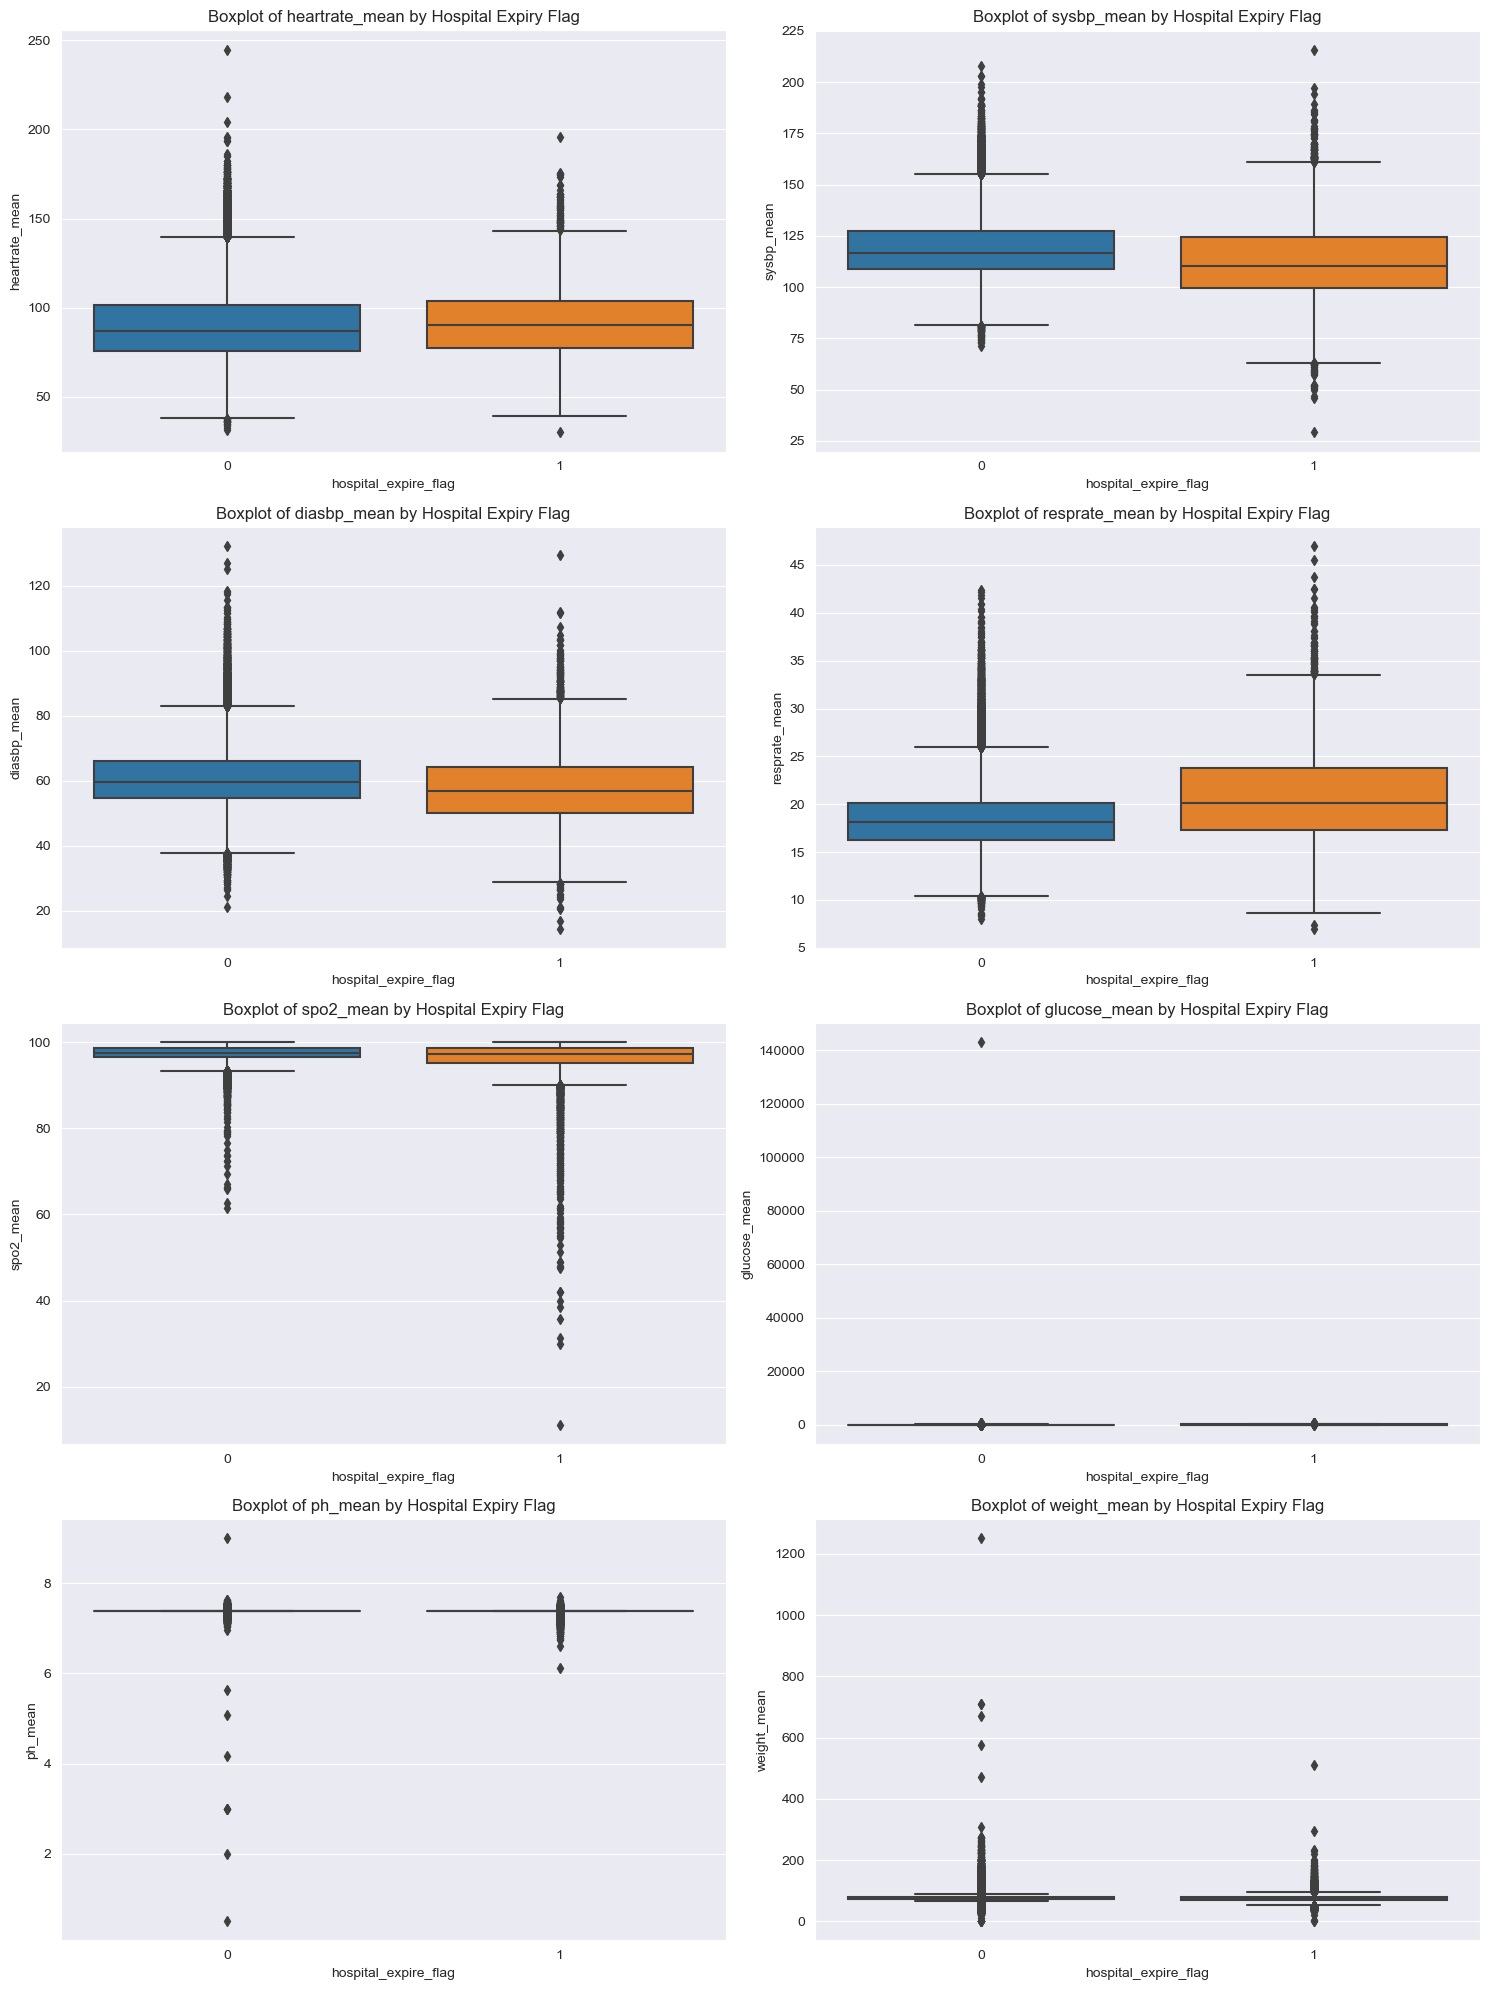

In [26]:
fig, axes = plt.subplots(4, 2, figsize=(15, 20))  # 4x2 subplots
axes = axes.ravel()

for i, vital_sign in enumerate(vital_signs):
    sns.boxplot(x='hospital_expire_flag', y=vital_sign, data=df2, ax=axes[i])
    axes[i].set_title(f'Boxplot of {vital_sign} by Hospital Expiry Flag')

plt.tight_layout()
plt.show()

### Feature Importance

In [29]:
df2 = pd.merge(df, admissions[['hadm_id', 'subject_id', 'icustay_id', 'hospital_expire_flag']], on=['hadm_id', 'subject_id', 'icustay_id'], how='left')
df2.head()

,subject_id,hadm_id,icustay_id,heartrate_min,heartrate_max,heartrate_mean,sysbp_min,sysbp_max,sysbp_mean,diasbp_min,...,glucose_min,glucose_max,glucose_mean,ph_min,ph_max,ph_mean,weight_min,weight_max,weight_mean,hospital_expire_flag
0,2,163353,243653,140.0,140.0,140.000000,91.0,147.0,116.473684,43.0,...,102.0,158.0,128.200000,7.34,7.42,7.38,77.400000,77.400002,77.400000,0
1,3,145834,211552,75.0,168.0,111.785714,64.0,217.0,102.960000,28.0,...,136.0,306.0,232.416667,7.26,7.59,7.36,96.800003,96.800003,96.800003,0
2,4,185777,294638,74.0,111.0,89.217391,97.0,139.0,118.000000,55.0,...,153.0,266.0,199.666667,7.34,7.42,7.38,77.400000,77.400002,77.400000,0
3,6,107064,228232,76.0,100.0,84.160000,127.0,187.0,153.647059,40.0,...,102.0,181.0,148.500000,7.34,7.42,7.38,77.400000,77.400002,77.400000,0
4,7,118037,236754,115.0,121.0,118.000000,91.0,147.0,116.473684,43.0,...,102.0,158.0,128.200000,7.34,7.42,7.38,77.400000,77.400002,77.400000,0


In [32]:
from preprocessing import apply_feature_importance

In [33]:
numerical_features = df.drop(columns=['hadm_id', 'subject_id', 'icustay_id']).columns
df_scaled = apply_feature_importance.scale_features(df=df2, numerical_features=numerical_features)

df_scaled.head()

,heartrate_min,heartrate_max,heartrate_mean,sysbp_min,sysbp_max,sysbp_mean,diasbp_min,diasbp_max,diasbp_mean,meanbp_min,...,spo2_mean,glucose_min,glucose_max,glucose_mean,ph_min,ph_max,ph_mean,weight_min,weight_max,weight_mean
0,2.678545,1.142139,2.093863,-0.055722,-0.090064,-0.131993,-0.046251,-0.133702,-0.088968,-0.021138,...,0.138887,-0.119739,-0.008222,-0.017497,0.049341,0.009312,0.029991,-0.097117,-0.097533,-0.097333
1,-0.105950,2.197617,0.871201,-1.618758,2.989291,-0.969394,-1.387746,-0.544760,-0.461928,-1.409111,...,0.275333,0.883344,0.027816,0.159711,-0.847840,2.745446,-0.282829,0.925514,0.924933,0.925290
2,-0.148788,0.048965,-0.106794,0.291620,-0.441990,-0.037412,1.026944,-0.133702,0.817595,0.827067,...,0.127137,1.384885,0.018076,0.104024,0.049341,0.009312,0.029991,-0.097117,-0.097533,-0.097333
3,-0.063111,-0.365687,-0.325956,2.028327,1.669568,2.171523,-0.314550,-0.662205,-0.381108,1.109805,...,0.806263,-0.119739,-0.002622,0.017021,0.049341,0.009312,0.029991,-0.097117,-0.097533,-0.097333
4,1.607586,0.425922,1.140496,-0.055722,-0.090064,-0.131993,-0.046251,-0.133702,-0.088968,-0.021138,...,0.138887,-0.119739,-0.008222,-0.017497,0.049341,0.009312,0.029991,-0.097117,-0.097533,-0.097333


In [42]:
df_scaled = pd.concat([df2['hospital_expire_flag'], df_scaled], axis=1)
df_scaled.head()

,hospital_expire_flag,heartrate_min,heartrate_max,heartrate_mean,sysbp_min,sysbp_max,sysbp_mean,diasbp_min,diasbp_max,diasbp_mean,...,spo2_mean,glucose_min,glucose_max,glucose_mean,ph_min,ph_max,ph_mean,weight_min,weight_max,weight_mean
0,0,2.678545,1.142139,2.093863,-0.055722,-0.090064,-0.131993,-0.046251,-0.133702,-0.088968,...,0.138887,-0.119739,-0.008222,-0.017497,0.049341,0.009312,0.029991,-0.097117,-0.097533,-0.097333
1,0,-0.105950,2.197617,0.871201,-1.618758,2.989291,-0.969394,-1.387746,-0.544760,-0.461928,...,0.275333,0.883344,0.027816,0.159711,-0.847840,2.745446,-0.282829,0.925514,0.924933,0.925290
2,0,-0.148788,0.048965,-0.106794,0.291620,-0.441990,-0.037412,1.026944,-0.133702,0.817595,...,0.127137,1.384885,0.018076,0.104024,0.049341,0.009312,0.029991,-0.097117,-0.097533,-0.097333
3,0,-0.063111,-0.365687,-0.325956,2.028327,1.669568,2.171523,-0.314550,-0.662205,-0.381108,...,0.806263,-0.119739,-0.002622,0.017021,0.049341,0.009312,0.029991,-0.097117,-0.097533,-0.097333
4,0,1.607586,0.425922,1.140496,-0.055722,-0.090064,-0.131993,-0.046251,-0.133702,-0.088968,...,0.138887,-0.119739,-0.008222,-0.017497,0.049341,0.009312,0.029991,-0.097117,-0.097533,-0.097333


In [43]:
# Applying Feature Importance using Random Forest
rf_importance, rf_accuracies = apply_feature_importance.get_feature_importance(df=df_scaled, classifier='rf')

for feature, importance in rf_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: sysbp_min, Importance: 0.053175389497691565
Feature: resprate_mean, Importance: 0.05245058345509454
Feature: spo2_mean, Importance: 0.05207136522615924
Feature: tempc_mean, Importance: 0.04972202152197083
Feature: sysbp_mean, Importance: 0.04532149576309603
Feature: heartrate_mean, Importance: 0.041550518539896594
Feature: spo2_min, Importance: 0.03905349882600383
Feature: tempc_max, Importance: 0.03848117615019565
Feature: meanbp_min, Importance: 0.03817000725393523
Feature: heartrate_min, Importance: 0.0379571191752562
Feature: tempc_min, Importance: 0.037219773714085296
Feature: glucose_mean, Importance: 0.036656685090393396
Feature: heartrate_max, Importance: 0.03580303571772816
Feature: glucose_min, Importance: 0.035797189305269615
Feature: meanbp_mean, Importance: 0.033691399849646544
Feature: diasbp_mean, Importance: 0.033435749903352976
Feature: glucose_max, Importance: 0.030941667387857023
Feature: diasbp_max, Importance: 0.0288420749829154
Feature: meanbp_max, Import

In [15]:
# # Distribution Plot
# for vital_sign in vital_signs:
#     sns.displot(df, x=vital_sign)
#     plt.title('Distribution of ' + vital_sign)
#     plt.show()

In [16]:
# # Histograms
# df[['heartrate_mean',
#     'sysbp_mean',
#     'diasbp_mean',
#     'meanbp_mean',
#     'resprate_mean',
#     'tempc_mean',
#     'spo2_mean',
#     'glucose_min']].hist(bins=50, figsize=(20,15))
# plt.tight_layout()
# plt.show()

In [17]:
# admissions = pd.read_csv('../dataset/patient_stay_data.csv')
# print(admissions.head())

In [18]:
# merged_df = pd.merge(df, admissions[['hadm_id', 'expire_flag']], on='hadm_id', how='left')

In [19]:
# import seaborn as sns
#
# vital_signs = ['heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean', 'resprate_mean', 'tempc_mean',
#                'spo2_mean', 'glucose_min']
#
# n_rows = 2
# n_cols = 4
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 10))
#
# for i, vital_sign in enumerate(vital_signs):
#     row = i // n_cols
#     col = i % n_cols
#
#     sns.boxplot(x='expire_flag', y=vital_sign, data=merged_df, ax=axs[row, col])
#     axs[row, col].set_title(f'{vital_sign} by Outcome')
#
# plt.tight_layout()
# plt.show()